In [1]:
import os
import torch
from nntool.api import NNGraph
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib widget
import logging
logging.basicConfig(level=logging.ERROR)
import torch
from obd1.models import yolo_base,ann_new_model_2
from obd1.dataset import evCIVIL
from torch.utils.data import DataLoader
#from lava.lib.dl import slayer

In [2]:
G = NNGraph.load_graph("/home/udayanga/Udaya_Research_stuff/2024_GAP8_work/gap8_special_course/image_checkpoints/simple_PTQ_model.tflite", load_quantization=True)
#G = NNGraph.load_graph("./model_yolov3_defect_detector_2.tflite", load_quantization=True)
ops = G.total_ops
G.draw(filepath="draw", view=True)

In [3]:
print(f"{G.name}:")
print(f"\tTotal # Operations:\t{ops / 1e6:.2f} MOps")

simple_PTQ_model:
	Total # Operations:	183.47 MOps


In [4]:
G.adjust_order()
G.fusions('scaled_match_group')
G.fusions('expression_matcher')
G.draw()

In [5]:
print(G.qshow())

+------+----------------+--------+----------------+----------------+----------------+----------------+-------------+----------------+----------------+
| Step |      Name      |  Type  |       In       |      Out       |    Weights     |      Bias      |   Mulbias   |      Calc      |      Acc       |
+======+================+========+================+================+================+================+=============+================+================+
|  0   | input_1        | scaled |                | -1.00<(i8-0.00 |                |                |             |                |                |
|      |                |        |                | )*0.00781250<0 |                |                |             |                |                |
|      |                |        |                | .99 forced     |                |                |             |                |                |
+------+----------------+--------+----------------+----------------+----------------+---------

In [6]:
dataset_path = '/home/udayanga/latest_dataset/'
train_csv_file = "night_outdoor_and_daytime_train_files_image_based.txt"
test_csv_file = "test_files_image_based.txt"
param_dict = {"TSteps" : 7, "tbins" : 1 ,"quantized_h" : 260 ,"quantized_w" : 346}

In [7]:
in_channels = 1
num_anchors = 3
num_classes = 2
num_output = num_anchors * (5 + num_classes)
tgt_iou_thr = 0.5
conf_thres = 0.6

In [8]:
net_dummy = ann_new_model_2.Network(in_channels=in_channels,num_classes=2,clamp_max=5.)
net_dummy.init_model((320,320),1)

In [9]:
yolo_target = yolo_base.YOLOtarget(anchors= net_dummy.anchors,
                                 scales= net_dummy.scale,
                                 num_classes=net_dummy.num_classes,
                                 ignore_iou_thres=tgt_iou_thr)

In [9]:
train_set = evCIVIL.evCIVIL(root = dataset_path ,csv_file_name = train_csv_file , param_dict = param_dict, train = True,augment = False)
test_set = evCIVIL.evCIVIL(root = dataset_path, csv_file_name= test_csv_file, param_dict = param_dict, train = False, augment = False)

prepare_loader = DataLoader(train_set,
                                batch_size=1,
                                shuffle=True,
                                collate_fn=yolo_target.collate_fn,
                                num_workers=1,
                                pin_memory=True)
test_loader = DataLoader(test_set,
                                batch_size=1,
                                shuffle=False,
                                collate_fn=yolo_target.collate_fn,    
                                num_workers=1,
                                pin_memory=True)

In [18]:
def representative_dataset():
    i = 0
    for i, (inputs, targets, bboxes) in enumerate(prepare_loader):
        # Pass a batch of images through the model
        inputs = inputs.permute(4,0,1,2,3)
        #print("input 1 shape ",inputs.shape)
        #print("targets shape ",targets[0][0].shape) #batch,scale,numpy_array
        #print("bboxes shape ",bboxes[0][0].shape)
        inputs = inputs.squeeze(0)
        inputs = inputs.to('cpu')
        inputs = inputs.squeeze(0)
        #print("input 2 shape ",inputs.shape)
        yield [inputs.numpy().astype(np.float32)]
        i += 1
        if i == 10:
            break


In [12]:
stats = G.collect_statistics(representative_dataset())

In [13]:
G.quantize(
    #statistics=stats,
    graph_options={
        'bits': 8,
    },
)

In [10]:
G.draw(quant_labels=True)

In [11]:
print(G.qshow())

+------+----------------+--------+----------------+----------------+----------------+----------------+-------------+----------------+----------------+
| Step |      Name      |  Type  |       In       |      Out       |    Weights     |      Bias      |   Mulbias   |      Calc      |      Acc       |
+======+================+========+================+================+================+================+=============+================+================+
|  0   | input_1        | scaled |                | -1.00<(i8-0.00 |                |                |             |                |                |
|      |                |        |                | )*0.00781250<0 |                |                |             |                |                |
|      |                |        |                | .99 forced     |                |                |             |                |                |
+------+----------------+--------+----------------+----------------+----------------+---------

In [18]:
selected_data_path = "/home/udayanga/Udaya_Research_stuff/2024_GAP8_work/gap8_special_course/daytime_images/"
selected_csv_file = selected_data_path + "/data.txt"

In [19]:
selected_test_set = evCIVIL.evCIVIL(root = selected_data_path, csv_file_name= selected_csv_file, param_dict = param_dict, train = False, augment = False)
selected_test_loader = DataLoader(selected_test_set,
                                batch_size=1,
                                shuffle=False,
                                collate_fn=yolo_target.collate_fn,    
                                num_workers=1,
                                pin_memory=True)

In [20]:
len(selected_test_set)

4

In [21]:
with open(selected_csv_file,"r") as f:
    print(f.readlines())

['spalling_24_2027044.npz\n', 'crack_151_2767313.npz\n', 'crack_72_391368.npz\n', 'spalling_3_7652617.npz\n']


In [22]:
fmaps_list = []
bboxes_list = []
num_bboxes_per_sample_list = []
count = 0
collect_inputs_from_ints = []
for i, (inputs, targets, bboxes) in enumerate(selected_test_loader):
    inputs = inputs.permute(4,0,1,2,3)
    
    inputs = inputs.squeeze(0)
    inputs = inputs.to('cpu')
    inputs = inputs.squeeze(0)
    
    #print("input 2 shape ",inputs.shape)
    input_data = [inputs.numpy().astype(np.float32)]
    #print("input 1 shape ",inputs.shape," ",inputs.min(),"  ",inputs.max())
    float_execution = G.execute(input_data, quantize=False)
    quant_execution = G.execute(input_data, quantize=True, dequantize=True)
    int_execution = G.execute(input_data, dequantize=False, quantize=True)
    #print("float_execution[31][0] shape ",float_execution[31][0].shape)
    print("float execution ",float_execution[31][0].max()," ",float_execution[31][0].min()," ",float_execution[31][0].mean())
    print("quant execution ",quant_execution[31][0].max()," ",quant_execution[31][0].min()," ",quant_execution[31][0].mean())
    print("int execution last ",int_execution[31][0].max()," ",int_execution[31][0].min()," ",int_execution[31][0].mean())
    #print("int execution first ",int_execution[0][0].max()," ",int_execution[0][0].min()," ",int_execution[0][0].mean())
    collect_inputs_from_ints.extend(int_execution[0])
    #print("float execution ",float_execution[28][0].shape)
    #print("quant execution ",quant_execution[28][0].max())
    #print("quant execution ",int_execution[28][0].max())
    fmaps_list.append(float_execution[28][0])
    num_bboxes_per_sample_list.append(bboxes[0][0].shape[0])
    bboxes_list.append(bboxes[0][0]) #as batch dim and scale dimension are appeared as two lists.

float execution  3.4530041   0.0   0.8152216
quant execution  3.3989406161479594   0.0   0.8170019306192182
int execution last  67   0   16.104761904761904
float execution  3.801257   0.0   0.9488578
quant execution  3.500401530062824   0.0   0.9464853826629499
int execution last  69   0   18.65714285714286
float execution  3.8047364   0.0   0.85217977
quant execution  3.754053814849985   0.0   0.8520784180012142
int execution last  74   0   16.796190476190475
float execution  3.7599418   0.0   0.8214525
quant execution  3.804784271807417   0.0   0.821543514384931
int execution last  75   0   16.194285714285716


In [23]:
## Dequantization formula
#X=Q×scale+min ; Q is the integer value after quantization, X is the dequantized value

In [32]:
len(collect_inputs_from_ints)

4

In [33]:
for elem in collect_inputs_from_ints:
    print(elem.shape)

(1, 320, 320)
(1, 320, 320)
(1, 320, 320)
(1, 320, 320)


In [37]:
quant_execution[0][0].max()

254.99999952316284

In [22]:
float_execution[28][0].shape

(21, 5, 5)

In [45]:
assert len(num_bboxes_per_sample_list) == len(bboxes_list) == len(fmaps_list)
quant_results_arr = np.stack(fmaps_list)
bboxes_merged_arr = np.concatenate(bboxes_list)
num_boxes_arr = np.array(num_bboxes_per_sample_list)
print(quant_results_arr.shape)
print(bboxes_merged_arr.shape)
print(num_boxes_arr.shape)

(6, 21, 5, 5)
(6, 6)
(6,)


In [46]:
np.save('float_fmaps.npy',quant_results_arr)
np.save('float_anns.npy',bboxes_merged_arr)
np.save('float_num_boxes.npy',num_boxes_arr)

In [34]:
from nntool.graph.types import ConstantInputNode
qsnrs_by_layer = G.qsnrs(float_execution, quant_execution)
print("QSNR layer by layer (skipping constant layers like weights and biases):")
print(f"{'Layer Name':>30} (  #): {'QSNR':4}")
for i, q in enumerate(qsnrs_by_layer):
    if isinstance(G[i], ConstantInputNode):
        continue
    print(f"{G[i].name:>30} ({i:3}): {q:4}")

QSNR layer by layer (skipping constant layers like weights and biases):
                    Layer Name (  #): QSNR
                       input_1 (  0):  inf
            CONV_2D_0_3_fusion (  3):   28
            CONV_2D_0_7_fusion (  6):   25
           CONV_2D_0_12_fusion (  9):   22
           CONV_2D_0_16_fusion ( 12):   21
           CONV_2D_0_21_fusion ( 15):   21
           CONV_2D_0_25_fusion ( 18):   21
           CONV_2D_0_29_fusion ( 21):   22
           CONV_2D_0_33_fusion ( 24):   23
           CONV_2D_0_37_fusion ( 27):   23
           CONV_2D_0_38_fusion ( 30):   26
                      output_1 ( 31):   26


In [35]:
G[0].at_options.allocate = 1
G[0].at_options

{'ALLOCATE': 1}

In [36]:
int_execution[28][0].max()

127

In [37]:
int_execution[0]

[array([[[-128, -128, -128, ..., -128, -128, -128],
         [-128, -128, -128, ..., -128, -128, -128],
         [-128, -128, -128, ..., -128, -128, -128],
         ...,
         [-128, -128, -128, ..., -128, -128, -128],
         [-128, -128, -128, ..., -128, -128, -128],
         [-128, -128, -128, ..., -128, -128, -128]]], dtype=int8)]

In [38]:
collect_inputs_from_ints[0]

array([[[-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128],
        ...,
        [-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128]]], dtype=int8)

In [39]:
collect_inputs_from_ints_2 = collect_inputs_from_ints

In [40]:
collect_inputs_from_ints_2.extend(collect_inputs_from_ints)

In [41]:
len(collect_inputs_from_ints_2)

8

In [52]:
res = G.execute_on_target(
pmsis_os='freertos',
platform="gvsoc",
directory="test_run",
input_tensors=[collect_inputs_from_ints_2[0]],
output_tensors=0,
source='gapuino_v3',
performance=True,
#write_out_to_file=True,
at_log=True,
dont_run=False,
settings={
'l1_size': 64000,
'l2_size': 320000,
'tensor_directory': './tensors'
},
#cmake=True,
at_loglevel=1,
print_output=True
)

for l in res.at_log[-29:-1]:
    print(l)

Script started, file is /tmp/tmp7bz78ucy/log.txt

make: Entering directory '/home/udayanga/Udaya_Research_stuff/2024_GAP8_work/yolov3_ann_model_images/test_run'
GEN ... 
Building NNTOOL model

script nntool_script
GEN ... /home/udayanga/gap_sdk/tools/autotiler_v3/CNN_Generators/CNN_Generator_Util.c /home/udayanga/gap_sdk/tools/autotiler_v3/CNN_Generators/CNN_Copy_Generators.c /home/udayanga/gap_sdk/tools/autotiler_v3/CNN_Generators/SSD_Generators.c /home/udayanga/gap_sdk/tools/autotiler_v3/Generators/BilinearResizes/ResizeGenerator.c  /home/udayanga/gap_sdk/tools/autotiler_v3/DSP_Generators/DSP_Generators.c /home/udayanga/gap_sdk/tools/autotiler_v3/CNN_Generators_SQ8/CNN_Generators_SQ8.c /home/udayanga/gap_sdk/tools/autotiler_v3/CNN_Generators_SQ8/RNN_Generators_SQ8.c

APP_SRCS... simple_PTQ_model.c BUILD_MODEL/simple_PTQ_modelKernels.c Expression_Kernels.c /home/udayanga/gap_sdk/libs/gap_lib/img_io/ImgIO.c /home/udayanga/gap_sdk/tools/autotiler_v3/CNN_Libraries/SSD_BasicKernels.c /hom

In [53]:
cyc_per_layer = np.array(res.performance)[:-1, 1].astype(np.int32)
opcyc_per_layer = np.array(res.performance)[:-1, 3].astype(np.float32)
perc_per_layer = np.array(res.performance)[:-1, -1].astype(np.float32)
names = np.array(res.performance)[:-1, 0]
def print_perf_layer(res):
    layer_idx = [n.split("_")[0][1:] for n in names]
    #print(cyc_per_layer)
    print(f"{'Layer':>40} | {'Cycles':8} | {'Op':10} | {'Op/Cyc':8} | {'%':8}\n")
    for n, cyc, op, opcyc, perc_cyc, perc_ops in res.performance:
        if n == "Total":
            print()
        print(f"{n:>40} | {cyc:8} | {op:10} | {float(opcyc):8.2f} | {float(perc_cyc):8.2f}")

In [55]:
print(re)

NameError: name 're' is not defined

In [56]:
cyc_per_layer

array([ 1624285, 24780458,  3024799,  5760517,   717554,   574884,
         574011,   938603,   937918,    13068], dtype=int32)

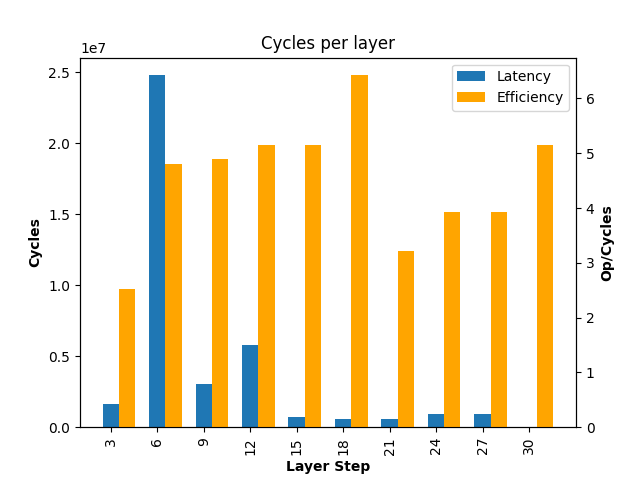

In [57]:
fig, ax = plt.subplots()
barWidth = 0.35

# Set position of bar on X axis
br1 = np.arange(len(cyc_per_layer))
br2 = [x + barWidth for x in br1]

lns = []
lns.append(
    ax.bar(br1, cyc_per_layer, width = barWidth, label="Latency")
)
ax1 = ax.twinx()
lns.append(
    ax1.bar(br2, opcyc_per_layer, width = barWidth, color="orange", label="Efficiency")
)
ax.set_xlabel('Layer Step', fontweight ='bold')#, fontsize = 15)
ax.set_ylabel('Cycles', fontweight ='bold')#, fontsize = 15)
ax1.set_ylabel('Op/Cycles', fontweight ='bold')#, fontsize = 15)
ax.set_xticks([r for r in range(len(names))])

# Set x-tick labels with rotation
ax.set_xticklabels([name.split("_")[0][1:] for name in names], rotation=90)

#ax.set_xticks([r for r in range(len(names))], [name.split("_")[0][1:] for name in names], rotation=90)
ax.set_title("Cycles per layer")

labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right")
plt.show()

In [45]:
cyc_per_layer

array([ 1624285, 24780458,  3024799,  5760517,   717554,   574884,
         574011,   938603,   937918,    13068], dtype=int32)

In [58]:
temp = np.array([ 2690753, 12773471,  3023609,  5769845,   716410,   577323,
         570683,   935451,    13257], dtype=np.int32)

In [59]:
np.sum(cyc_per_layer) / (175000000)

0.2225491257142857

In [ ]:
def calculate_detection_scores(ground_truth_indices,pred_fmaps):

    data_path = "/home/atiye/latest_dataset/"
    test_csv_file = "test_files_event_based.txt"
    param_dict = {"TSteps" : 7, "tbins" : 1 ,"quantized_h" : 260 ,"quantized_w" : 346}
    full_set = evCIVIL(root = data_path, csv_file_name= test_csv_file, param_dict = param_dict, train = False, augment = False)
    
    valid_TSteps = 7
    stats = slayer.utils.LearningStats(accuracy_str='AP@0.5')
    ap_stats = metrics.APstats(iou_threshold=0.5)
    anchors = torch.tensor([[0.2800, 0.2200],
        [0.3800, 0.4800],
        [0.9000, 0.7800]])
    anchors = anchors.unsqueeze(0)
    conf_thres = 0.1

    for i,ground_truth_id,pred_fmap in enumerate(zip(ground_truth_indices,pred_fmaps)):

        _,bboxes = full_set.__getelement__(ground_truth_id)

        pred_fmap = pred_fmap.unsqueeze(0) #add batch dim at the begining
        pred_fmap = pred_fmap.unsqueeze(-1) #add time dimension
        #now batch,C,H,W,T dimension
        predictions = yolo_raw(predictions)
        predictions = [predictions]
        
        predictions = [prediction/(valid_TSteps + 0.0) for prediction in predictions]
        T = 1 #inputs.shape[-1]  #This means prediction should be done at the last time step
        try:
            predictions = torch.concat([yolo(p, a) for (p, a)
                        in zip(predictions, anchors)],dim=1)
        except RuntimeError:
            print('Runtime error on MAP predictions calculation.'
                            'continuing')
            continue
        predictions = [utils.nms(predictions[..., t],conf_threshold = conf_thres)
                            for t in range(T)]
            
        for t in range(T):
                ap_stats.update(predictions[t],[bboxes]) #bboxes is torch array, predictions[t] is a list. in that list torch.tensor of (75,6) (5x5x3,6)
        
        stats.testing.num_samples += 1
        stats.testing.correct_samples = ap_stats[:] * stats.testing.num_samples

    print("stats.testing.accuracy ",stats.testing.accuracy)
    stats.update()

In [ ]:
def _yolo(x: torch.tensor,
          anchors: torch.tensor,
          clamp_max: float = 5.0) -> torch.tensor:
    # converts raw predictions to bounding box predictions.
    _, _, H, W, _, _ = x.shape
    range_y, range_x = torch.meshgrid(
        torch.arange(H, dtype=x.dtype, device=x.device),
        torch.arange(W, dtype=x.dtype, device=x.device),
        indexing='ij',
    )
    anchor_x, anchor_y = anchors[:, 0], anchors[:, 1]

    x_center = (torch.sigmoid(x[:, :, :, :, 0:1, :])
                + range_x[None, None, :, :, None, None]) / W
    y_center = (torch.sigmoid(x[:, :, :, :, 1:2, :])
                + range_y[None, None, :, :, None, None]) / H
    width = (torch.exp(
        x[:, :, :, :, 2:3, :].clamp(
            max=clamp_max)) * anchor_x[None, :, None, None, None, None]) / W
    height = (torch.exp(
        x[:, :, :, :, 3:4, :].clamp(
            max=clamp_max)) * anchor_y[None, :, None, None, None, None]) / H
    confidence = torch.sigmoid(x[:, :, :, :, 4:5, :])
    classes = torch.softmax(x[:, :, :, :, 5:, :], dim=-2)
    #classes = torch.sigmoid(x[:, :, :, :, 5:, :])

    x = torch.concat([x_center, y_center, width, height,
                      confidence, classes], dim=-2)

    if torch.isnan(x).any() or torch.isinf(x).any():
        print(f'{torch.isnan(x_center).any()=}')
        print(f'{torch.isinf(x_center).any()=}')
        print(f'{torch.isnan(y_center).any()=}')
        print(f'{torch.isinf(y_center).any()=}')
        print(f'{torch.isnan(width).any()=}')
        print(f'{torch.isinf(width).any()=}')
        print(f'{torch.isnan(height).any()=}')
        print(f'{torch.isinf(height).any()=}')
        raise RuntimeError('Ecountered NaN and Inf!')

    return x  # batch, anchor, height, width, predictions, time 



def yolo(x: torch.tensor, anchors: torch.tensor) -> torch.tensor:
        """Evaluates YOLO bounding box prediction from raw network output.

        Parameters
        ----------
        x : torch.tensor
            Raw prediciton tensor.
        anchors : torch.tensor
            Anchors associated with the prediction head.

        Returns
        -------
        torch.tensor
            Output bounding boxes.
        """
        clamp_max = 5.0
        N, _, _, _, P, T = x.shape
        return _yolo(x, anchors, clamp_max).reshape([N, -1, P, T])

def yolo_raw(x: torch.tensor) -> torch.tensor:
        """Transforms raw YOLO prediction to eventual output order i.e.
        NCHWT order to (batch, num_anchors, num_outputs, height, width, time).

        Parameters
        ----------
        x : torch.tensor
            Raw prediction output of the network.

        Returns
        -------
        torch.tensor
            Transformed raw prediction output for a head.
        """
        num_anchors = 3

        N, _, H, W, T = x.shape
        return x.reshape(N,num_anchors,-1, H, W, T).permute(0, 1, 3, 4, 2, 5)

        """T, N, _, H, W = x.shape
        return x.reshape(T,N,
                         num_anchors,
                         -1, H, W).permute(1, 2, 4, 5, 3, 0) # now (batch,anchors,h,w,-1,T)"""